## 📺 Netflix Data: Cleaning, Analysis, and Visualization
This project explores Netflix's content data from 1925 to 2021 to uncover insights about content trends, duration, countries, genres, and more. It includes data cleaning, exploratory data analysis (EDA), feature engineering, and a machine learning model to predict content type (Movie or TV Show).

## Step 1: Import Libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

import joblib

## Step 2 : Load and view Dataset
- Load dataset
- Display shape and first 5 rows

In [18]:
df = pd.read_excel("Netflix.xlsx")
df.shape, df.head()

((8790, 10),
   show_id     type                             title         director  \
 0      s1    Movie              Dick Johnson Is Dead  Kirsten Johnson   
 1      s3  TV Show                         Ganglands  Julien Leclercq   
 2      s6  TV Show                     Midnight Mass    Mike Flanagan   
 3     s14    Movie  Confessions of an Invisible Girl    Bruno Garotti   
 4      s8    Movie                           Sankofa     Haile Gerima   
 
          country date_added  release_year rating  duration  \
 0  United States  9/25/2021          2020  PG-13    90 min   
 1         France  9/24/2021          2021  TV-MA  1 Season   
 2  United States  9/24/2021          2021  TV-MA  1 Season   
 3         Brazil  9/22/2021          2021  TV-PG    91 min   
 4  United States  9/24/2021          1993  TV-MA   125 min   
 
                                            listed_in  
 0                                      Documentaries  
 1  Crime TV Shows, International TV Shows, TV Ac

## Step 3: Data Cleaning

In [26]:
# Check for null values
nulls = df.isnull().sum()

# Drop rows with missing type, title or release_year
df_cleaned = df.dropna(subset=['type', 'title', 'release_year'])

# Fill missing 'country', 'director', 'rating' with 'Unknown'
df_cleaned['country'].fillna('Unknown', inplace=True)
df_cleaned['director'].fillna('Unknown', inplace=True)
df_cleaned['rating'].fillna('Unknown', inplace=True)

# Convert 'date_added' to datetime
df_cleaned['date_added'] = pd.to_datetime(df_cleaned['date_added'], errors='coerce')

# Split 'duration' into numeric and unit
df_cleaned[['duration_num', 'duration_unit']] = df_cleaned['duration'].str.extract(r'(\d+)\s*(\w+)')
df_cleaned['duration_num'] = pd.to_numeric(df_cleaned['duration_num'], errors='coerce')

# Remove duplicates
df_cleaned.drop_duplicates(inplace=True)

# Show shape after cleaning and check for remaining nulls
df_cleaned.shape, df_cleaned.isnull().sum()


((8790, 12),
 show_id          0
 type             0
 title            0
 director         0
 country          0
 date_added       0
 release_year     0
 rating           0
 duration         0
 listed_in        0
 duration_num     0
 duration_unit    0
 dtype: int64)

## Step 4: Exploratory Data Analysis (EDA)
- Count of Movies vs TV Shows
- Content added per year (based on 'date_added')
- Top 10 genres
- Country-wise content (top 10)

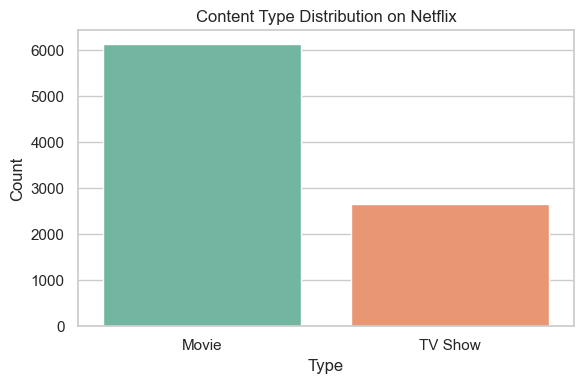

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# Set style for all plots
sns.set(style="whitegrid")

# Count of Movies vs TV Shows
plt.figure(figsize=(6, 4))
sns.countplot(data=df_cleaned, x='type', palette='Set2')
plt.title('Content Type Distribution on Netflix')
plt.xlabel('Type')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

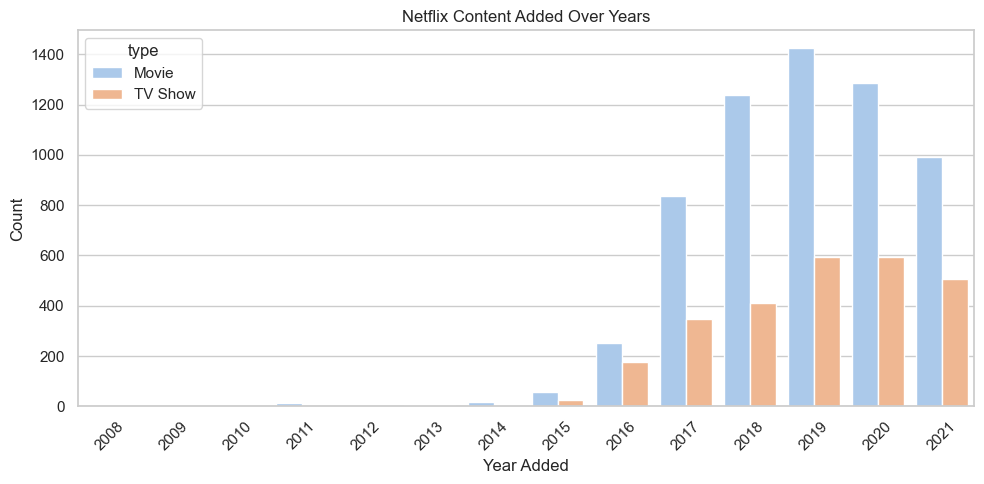

In [ ]:
# Content added per year (based on 'date_added')

plt.figure(figsize=(10, 5))
df_cleaned['year_added'] = df_cleaned['date_added'].dt.year
sns.countplot(data=df_cleaned, x='year_added', hue='type', palette='pastel')
plt.xticks(rotation=45)
plt.title('Netflix Content Added Over Years')
plt.xlabel('Year Added')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

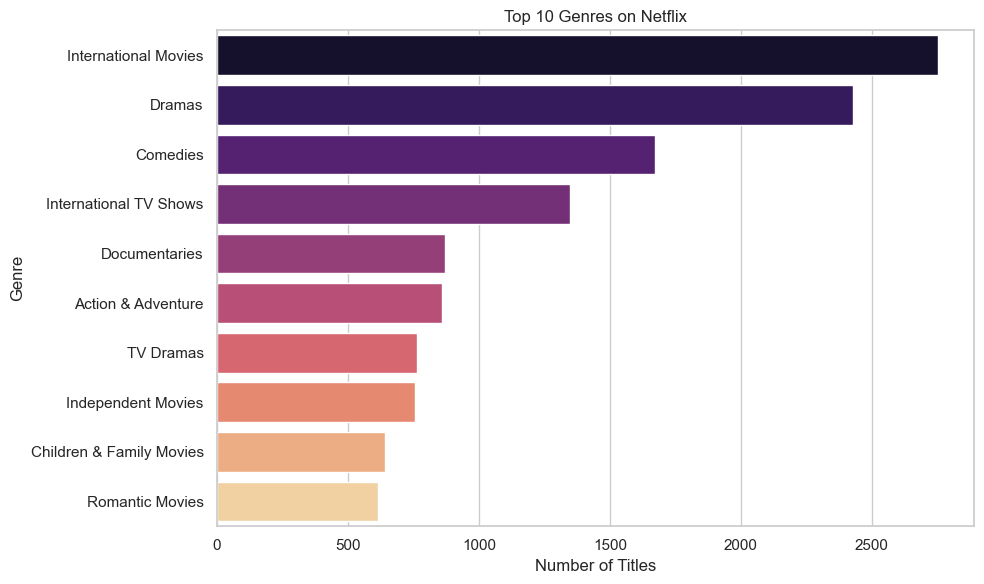

In [ ]:
# Top 10 genres
from collections import Counter

# Explode 'listed_in' by splitting by commas
genre_series = df_cleaned['listed_in'].str.split(', ')
genres_flat = [genre for sublist in genre_series for genre in sublist]
top_genres = pd.Series(Counter(genres_flat)).sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_genres.values, y=top_genres.index, palette='magma')
plt.title('Top 10 Genres on Netflix')
plt.xlabel('Number of Titles')
plt.ylabel('Genre')
plt.tight_layout()
plt.show()

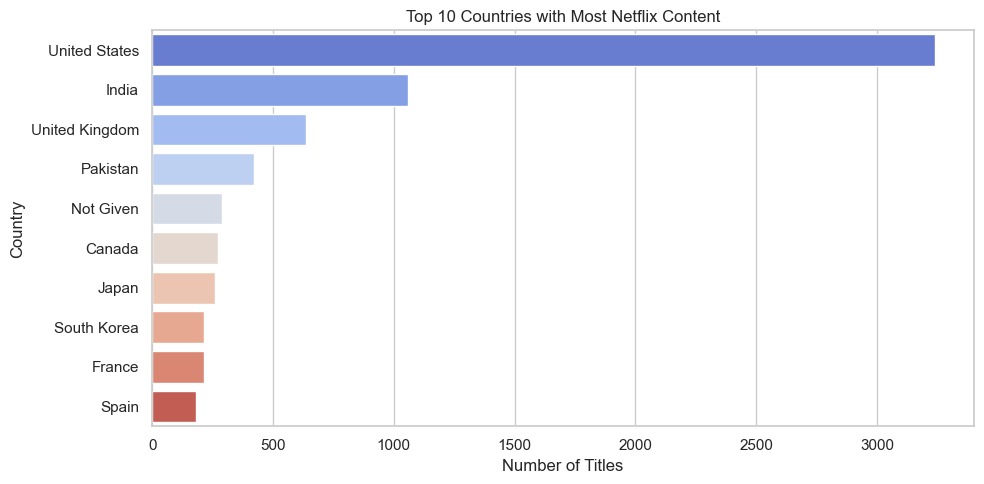

In [30]:
# 4. Country-wise content (top 10)
top_countries = df_cleaned['country'].value_counts().head(10)
plt.figure(figsize=(10, 5))
sns.barplot(x=top_countries.values, y=top_countries.index, palette='coolwarm')
plt.title('Top 10 Countries with Most Netflix Content')
plt.xlabel('Number of Titles')
plt.ylabel('Country')
plt.tight_layout()
plt.show()

## Step 5: Feature Engineering

In [ ]:
# Count the number of genres per title
df_cleaned['genre_count'] = df_cleaned['listed_in'].apply(lambda x: len(str(x).split(', ')))

# Extract content duration in minutes (if type is Movie)
df_cleaned['duration_min'] = df_cleaned.apply(
    lambda row: row['duration_num'] if row['type'] == 'Movie' else 0, axis=1
)

# Extract number of seasons (if type is TV Show)
df_cleaned['season_count'] = df_cleaned.apply(
    lambda row: row['duration_num'] if row['type'] == 'TV Show' else 0, axis=1
)

# Encode 'type' as binary target for ML (Movie = 0, TV Show = 1)
le = LabelEncoder()
df_cleaned['type_encoded'] = le.fit_transform(df_cleaned['type'])

# Encode 'rating' column
df_cleaned['rating_encoded'] = le.fit_transform(df_cleaned['rating'])

# Extract year/month added to Netflix
df_cleaned['month_added'] = df_cleaned['date_added'].dt.month
df_cleaned['day_added'] = df_cleaned['date_added'].dt.day

# View updated DataFrame with new features
df_cleaned[['title', 'type', 'genre_count', 'duration_min', 'season_count', 'type_encoded', 'rating_encoded']].head()


,title,type,genre_count,duration_min,season_count,type_encoded,rating_encoded
0,Dick Johnson Is Dead,Movie,1,90,0,0,4
1,Ganglands,TV Show,3,0,1,1,8
2,Midnight Mass,TV Show,3,0,1,1,8
3,Confessions of an Invisible Girl,Movie,2,91,0,0,9
4,Sankofa,Movie,3,125,0,0,8


## STEP 6: Machine Learning – Predict Content Type (Movie or TV Show)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
from sklearn.preprocessing import LabelEncoder

df_cleaned = df.copy()
df_cleaned['date_added'] = pd.to_datetime(df_cleaned['date_added'], errors='coerce')
df_cleaned['month_added'] = df_cleaned['date_added'].dt.month.fillna(0).astype(int)
df_cleaned['day_added'] = df_cleaned['date_added'].dt.day.fillna(0).astype(int)
df_cleaned['rating'] = df_cleaned['rating'].fillna("Unknown")
df_cleaned['rating_encoded'] = LabelEncoder().fit_transform(df_cleaned['rating'])
df_cleaned['type_encoded'] = LabelEncoder().fit_transform(df_cleaned['type'])
df_cleaned['duration_numeric'] = df_cleaned['duration'].str.extract('(\d+)').astype(float)
df_cleaned['duration_min'] = df_cleaned.apply(lambda row: row['duration_numeric'] if row['type'] == 'Movie' else 0, axis=1)
df_cleaned['season_count'] = df_cleaned.apply(lambda row: row['duration_numeric'] if row['type'] == 'TV Show' else 0, axis=1)
df_cleaned['genre_count'] = df_cleaned['listed_in'].fillna('').apply(lambda x: len(x.split(',')))
df_cleaned.dropna(subset=['release_year'], inplace=True)


# Select Features & Target
features = ['release_year', 'genre_count', 'duration_min', 'season_count', 'rating_encoded', 'month_added', 'day_added']
X = df_cleaned[features]
y = df_cleaned['type_encoded']  # Target: Movie = 0, TV Show = 1

# Train-test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict
y_pred = rf_model.predict(X_test)

# Evaluation
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))



Confusion Matrix:
 [[1238    0]
 [   0  520]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1238
           1       1.00      1.00      1.00       520

    accuracy                           1.00      1758
   macro avg       1.00      1.00      1.00      1758
weighted avg       1.00      1.00      1.00      1758



## STEP 7: Feature Importance

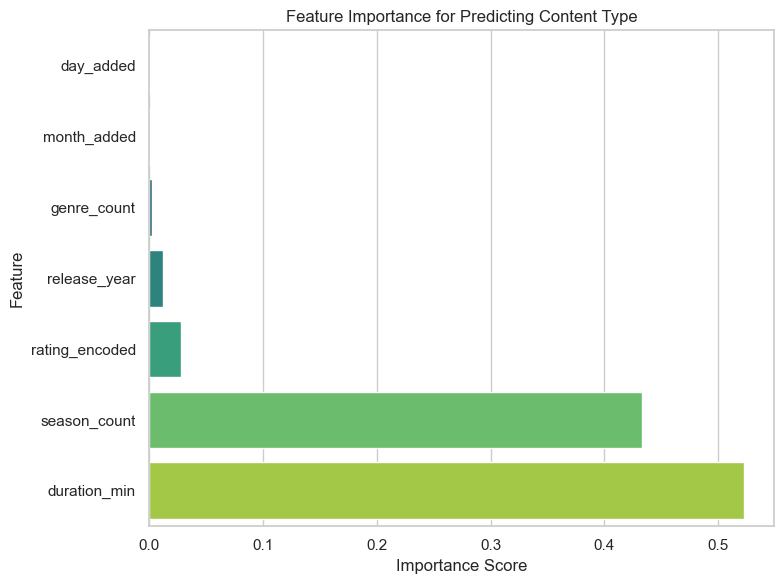

In [ ]:
importances = pd.Series(rf_model.feature_importances_, index=features)
importances = importances.sort_values(ascending=True)

# Plot
plt.figure(figsize=(8, 6))
sns.barplot(x=importances.values, y=importances.index, palette='viridis')
plt.title('Feature Importance for Predicting Content Type')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


## STEP 8: Save the Trained Model

In [ ]:
import joblib

model_filename = "netflix_content_type_model.pkl"
joblib.dump(rf_model, model_filename)

print(f"✅ Model saved as {model_filename}")


✅ Model saved as netflix_content_type_model.pkl


## 📈 Key Insights
- Movies dominate Netflix’s content, but TV Shows are growing in number.

- Most Netflix content originates from USA, India, and UK.

- The peak years for new additions were 2019–2020, likely due to COVID-19.

- Top genres: Dramas, Comedies, International content.

- Random Forest Model performs well in predicting content type with duration and release year as key indicators.

---